In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [ ]:
!pip install livelossplot
!pip install pytorch_forecasting
!pip install scikit-learn
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_ext

In [ ]:
import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np

from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.cluster import DBSCAN

import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

from livelossplot import PlotLosses

from joblib import Parallel, delayed
import joblib

import seaborn as sns

import math
import statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

import shap

from itertools import chain

import time
import joblib

In [ ]:

import warnings
warnings.filterwarnings('ignore')

In [ ]:
class SumAxis(nn.Module):
  def __init__(self, axis=1):
    super().__init__()
    self.axis=axis

  def forward(self, x):
    return torch.sum(x, axis=1)

In [ ]:
class StopNet(nn.Module):
  def __init__(self, features_in=21, activation=nn.ReLU):
    super().__init__()
    self.booking_embedding = nn.Sequential(
        nn.Linear(features_in, 128),
        activation(),
        nn.Linear(128, 128),
        # activation()
    )

    self.lstm = nn.LSTM(128, 128, 1, batch_first=True) #input size, hidden dim, n_layers

    self.stop_net = nn.Sequential(
        nn.Linear(128, 64),
        activation(),
        nn.Linear(64, 32),
        activation(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    """
    x shape: [batch_size, sequence_length, n_features]
    """
    seq_length = (~(x == 0).all(axis=2)).sum(axis=1).detach().tolist()
    seq_embedded = self.booking_embedding(x)  # output shape: [batch_size, sequence length, 128]
    packed_seq_bach = torch.nn.utils.rnn.pack_padded_sequence(seq_embedded, lengths = torch.Tensor(seq_length).to("cpu"), batch_first = True, enforce_sorted=False)
    _, (lstm_hidden, _) = self.lstm(packed_seq_bach) #IS misschien al de laatste, dan hoeft bij de volgende lijn geen -1 te stan tussen de brackets maar :
    stop_net_out = self.stop_net(lstm_hidden)
    return stop_net_out.squeeze(2)

In [ ]:
class HotelDataset(Dataset):
  def __init__(self, split='train'):
    """
    1. Load the data, e.g. df= pd.Feather load ()

    Data preprocessing:
    - Make sure fast indexing, so, maybe use guest_id as index
    - New time index, running from 1 (first time) ... last_time
    - Data needs to be all numerical, use encoders to encode data if needed before hand
    - Normalize data
    """
    self.scaled_df = pd.read_csv('output/10_selected_guest_data/df_original_data_standardscaler', index_col = [0,1])
    self.scaled_df = self.scaled_df.drop(["amount_times_visited", "weekday_arrival_date", "weekday_creation_date"], axis = 1)
    self.scaled_df.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.scaled_df.index])
    self.scaled_df = self.scaled_df.iloc[1:, :]
    missing_rows = self.scaled_df.isnull().any(axis = 1)
    self.scaled_df = self.scaled_df[~missing_rows]
    guests = self.scaled_df.index.get_level_values(0)
    # self.guest_idx = np.unique(self.scaled_df.index.get_level_values(0))
    self.guest_idx = np.unique([guests[0]] + list(guests[1:].astype(str)))
    self.split_indexes = self.train_test_split(split)
    self.y = pd.read_csv('output/10_selected_guest_data/y_original_data', index_col = [0,1])
    self.y.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.y.index])
    self.y = self.y[~missing_rows.values]
    return

  def train_test_split(self, split):
    max_guests = len(self.guest_idx)
    n = int(max_guests * 0.8)
    indexes = np.random.permutation(max_guests)

    if split == "train":
      return indexes[:n]
    elif split == "validation":
      return indexes[n:]

  def __len__(self):
    """
    np.unique(guests)
    """
    return len(self.split_indexes)

  def __getitem__(self, idx):
    """
    idx --> guest_id
    self.df[idx]
    """

    idx = self.split_indexes[idx]
    chosen_guest = self.scaled_df.loc[self.guest_idx[idx]]
    y_guest = self.y.loc[self.guest_idx[idx]]
    y_array = y_guest.to_numpy().squeeze(1)
    columns_guest = chosen_guest.columns
    guest_array = chosen_guest.to_numpy()  # [sequence length, columns]

    cut_off = np.random.randint(1, guest_array.shape[0] + 1) if guest_array.shape[0] > 1 else 1     #TODO: Het lijkt alsof hier iets mis gaat en altijd de laatste geskipt wordt

    return torch.Tensor(guest_array[:cut_off, :]), y_array[cut_off -1]


In [ ]:
class StopLoss(nn.Module):
  def __init__(self, last_event_weight=1):
    super().__init__()
    self.last_event_weight=1
    self.bce = nn.BCELoss()
    self.mse = nn.MSELoss(reduction='none')

  def forward(self, last_event_pred, y_target):
    target_last_event = (y_target == -1000).float() # It will become true or false --> make it 1 or 0
    bce_loss = self.bce(last_event_pred, target_last_event)

    return self.last_event_weight * bce_loss


In [ ]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def pad_batch(batch):
  booking_seqs, labels = zip(*batch)
  seq_length = [len(booking) for booking in booking_seqs]
  padded_booking_seqs = pad_sequence(booking_seqs, batch_first=True, padding_value=-10)
  return padded_booking_seqs, torch.Tensor(labels), seq_length

In [ ]:
model = StopNet(features_in=21)

data_train = HotelDataset(split='train')
data_validate = HotelDataset(split='validation')
# data_test = HotelDataset(split="test")


In [ ]:
train_loader = DataLoader(data_train, batch_size=256, collate_fn=pad_batch)
valid_loader = DataLoader(data_validate, batch_size=256, collate_fn=pad_batch)

optimizer = Adam(model.parameters()) # Default learning rate 0.001
loss_fn = StopLoss()
num_epochs = 20

In [ ]:
def train_stop(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, device = "cuda"):
  liveloss = PlotLosses()
  model.to(device)
  for epoch in range(num_epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    epoch_loss_train = 0.0
    for i,data in enumerate(train_loader):#, 0)
      inputs, labels, seq_length = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      stop_pred = model(inputs)

      loss = loss_fn(stop_pred, labels.unsqueeze(0))

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      epoch_loss_train += loss.item()
      if i % 200 == 199:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (200*32):.3f}')
          running_loss = 0.0

    logs['train_loss value'] = epoch_loss_train / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
      valid_loss = 0

      for i,data in enumerate(valid_loader):#, 0)
        inputs, labels, seq_length = data
        inputs, labels = inputs.to(device), labels.to(device)
        stop_pred = model(inputs)
        loss = loss_fn(stop_pred, labels.unsqueeze(0))
        valid_loss += loss.item()

      print(f'[validation {epoch + 1}] loss: {valid_loss / (i*32):.3f}')
    logs['valid_loss value'] = valid_loss / len(valid_loader.dataset)
    print(logs)
    liveloss.update(logs)
    liveloss.send()

In [ ]:
def predict(model, valid_loader, device = "cuda"):
  model.to(device)
  model.eval()
  stop_pred_list = []
  labels_list = []
  with torch.no_grad():
    for i,data in enumerate(valid_loader):#, 0)
      inputs, labels, seq_length = data
      seq_length = torch.Tensor(seq_length)
      inputs, labels, seq_length = inputs.to(device), labels.to(device), seq_length.to(device)
      # print(labels)
      stop_pred = model(inputs)
      stop_pred_list.extend(stop_pred.cpu().tolist())
      labels_list.extend(labels.cpu().tolist())
    labels_list = pd.Series(labels_list)


  return stop_pred_list, labels_list

To run ten times

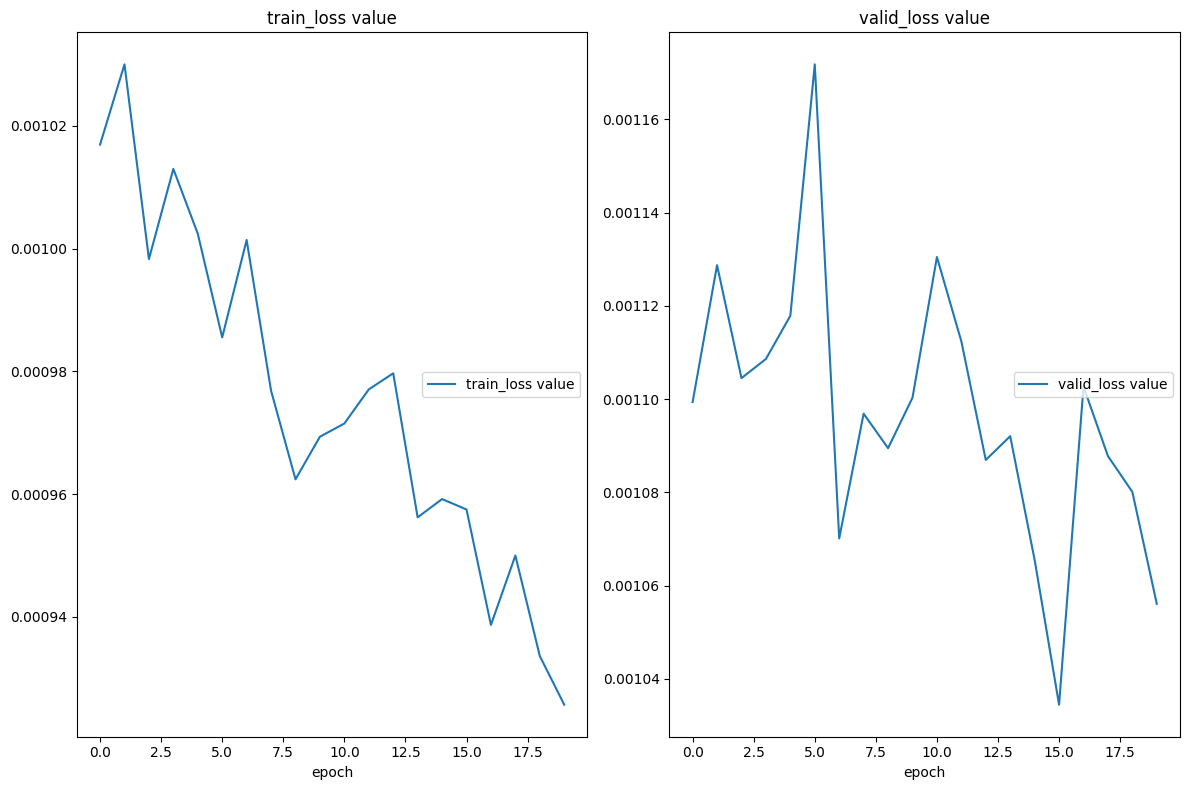

train_loss value
	train_loss value 	 (min:    0.001, max:    0.001, cur:    0.001)
valid_loss value
	valid_loss value 	 (min:    0.001, max:    0.001, cur:    0.001)


In [ ]:
import sklearn.metrics
from sklearn.metrics import accuracy_score
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
acc_score_list = []
for i in range(10):

  optimizer = Adam(model.parameters())
  loss_fn = StopLoss()
  num_epochs = 20
  start_time = time.time()
  train_stop(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs)
  t = time.time() - start_time
  t = round(t)
  time_list.append(t)
  joblib.dump(model, "Trained_models/lstmstop_model_finaloriginal_{0}_{1}.pkl".format(i, t))
  stop_pred_old, labels_old = predict(model, valid_loader)
  stop_pred_old = list(chain.from_iterable(stop_pred_old))
  stop_pred_old = pd.DataFrame(stop_pred_old)
  stop_pred = stop_pred_old.apply(lambda x: pd.cut(x, [-np.inf, 0.5, np.inf], labels = [0,1]))
  labels_old = pd.DataFrame(labels_old)
  labels = labels_old.apply(lambda x: pd.cut(x, [-np.inf, -1000, np.inf], labels = [1,0]))
  labels = labels.reset_index()
  labels = labels.drop(["index"], axis = 1)
  df_old = pd.concat([labels, stop_pred], axis = 1)
  df_old.columns = ["labels", "stop_pred"]
  df_sorted = df_old.copy()
  acc_score = accuracy_score(df_sorted["labels"], df_sorted["stop_pred"])

  precision_score = sklearn.metrics.precision_score(df_sorted["labels"], df_sorted["stop_pred"], average = "macro")
  recall_score = sklearn.metrics.recall_score(df_sorted["labels"], df_sorted["stop_pred"], average = "macro")
  f1_score = sklearn.metrics.f1_score(df_sorted["labels"], df_sorted["stop_pred"], average = "macro")

  acc_score_list.append(acc_score)
  precision_list.append(precision_score)
  recall_list.append(recall_score)
  f1_list.append(f1_score)

In [ ]:
print(np.mean(acc_score_list))
print(np.mean(precision_list))
print(np.mean(recall_list))
print(np.mean(f1_list))

**Confusion matrix**

In [ ]:
cm = confusion_matrix(df_sorted["labels"], df_sorted["stop_pred"])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn, index = ["not last event", "last event"], columns = ["not last event","last event"])

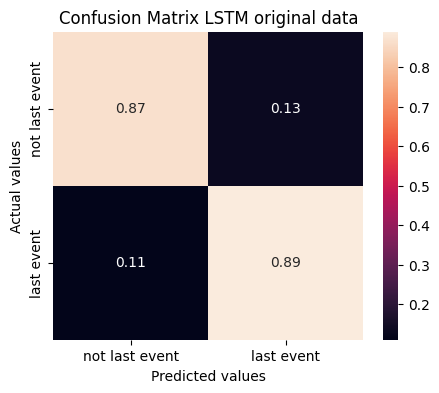

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True)
plt.title("Confusion Matrix LSTM original data")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

In [ ]:
class ShapData(Dataset):
  def __init__(self, X):

    self.X = X


  def __len__(self):
    # return len(self.guests)
    return len(self.X)

  def __getitem__(self, idx):
    return torch.Tensor(self.X[idx]).reshape(1, -1)

In [ ]:
def pad_batch_shap(batch):
  # print(batch[0].shape)
  booking_seqs = batch
  seq_length = [len(booking) for booking in booking_seqs]
  padded_booking_seqs = pad_sequence(booking_seqs, batch_first=True, padding_value=-10)
  return padded_booking_seqs, seq_length

In [ ]:
guest_idx_val = data_validate.guest_idx
scaled_df_val = data_validate.scaled_df
val_guest_idx = [data_validate.guest_idx[i] for i in data_validate.split_indexes]
scaled_df_val.index.get_level_values(0)

Index(['00006feb-5f2f-49dc-9a85-318f60e795a4',
       '00006feb-5f2f-49dc-9a85-318f60e795a4',
       '00006feb-5f2f-49dc-9a85-318f60e795a4',
       '0003bc13-8117-4e98-af2e-9d84e3721588',
       '0003bc13-8117-4e98-af2e-9d84e3721588',
       '0006255e-ea6b-4e2b-af7b-96e113d6caa1',
       '0006255e-ea6b-4e2b-af7b-96e113d6caa1',
       '0006255e-ea6b-4e2b-af7b-96e113d6caa1',
       '00064786-87ad-4904-830e-1f2bc29e4e6a',
       '00064786-87ad-4904-830e-1f2bc29e4e6a',
       ...
       'ffd398bb-5c7c-472e-a00a-b67ec091adfb',
       'ffd398bb-5c7c-472e-a00a-b67ec091adfb',
       'ffdbf658-f653-4411-ba02-51da0b4fd661',
       'ffdbf658-f653-4411-ba02-51da0b4fd661',
       'ffe153bd-1823-4361-8cd9-fd0a7eb5da7e',
       'ffe153bd-1823-4361-8cd9-fd0a7eb5da7e',
       'ffea76ba-71d6-47f7-82e5-74504fce130f',
       'ffea76ba-71d6-47f7-82e5-74504fce130f',
       'ffef83d5-c06c-4d49-b99b-9f717d47380f',
       'ffef83d5-c06c-4d49-b99b-9f717d47380f'],
      dtype='object', length=145530)

In [ ]:
def predict_shap(X):
  shap_data = ShapData(X)
  shap_loader = DataLoader(shap_data, batch_size=512, collate_fn=pad_batch_shap, shuffle=True)
  predictions_list = []

  for i, batch in enumerate(shap_loader):
    data, seq_length = batch

    predictions = model(data)
    predictions_list.extend(predictions.cpu().tolist()[0])

  return np.array(predictions_list)#predictions

In [ ]:
explainer = shap.KernelExplainer(predict_shap, shap.sample(scaled_df_val, 200), feature_names = scaled_df_val.columns)

  0%|          | 0/400 [00:00<?, ?it/s]

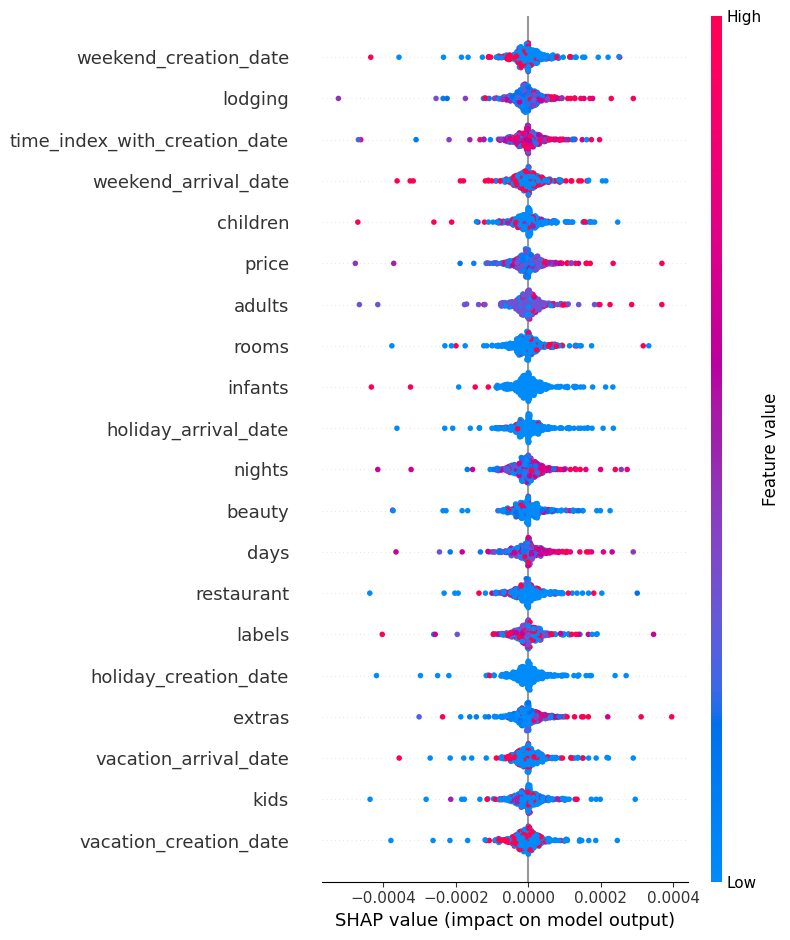

In [ ]:
shap_values = explainer.shap_values(shap.sample(scaled_df_val, 400))
shap.summary_plot(shap_values, shap.sample(scaled_df_val, 400))